# Bigram and Trigram analysis

In [48]:
import pandas as pd
import logging
from numpy import array
from numpy import argmax
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import pickle
import numpy as np
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings(action='ignore')
import time
import pprint
import pickle
import random
import numpy as np
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
from pprint import pprint 
from sklearn.metrics.pairwise import cosine_similarity
import json
import pandas as pd
import numpy as np
from collections import Counter, defaultdict
import spacy
from tqdm import tqdm_notebook
import nltk
from unidecode import unidecode
from functools import reduce
import operator
from collections import OrderedDict
import re
from nltk import FreqDist
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer 
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
import itertools
from datetime import datetime

In [49]:
nlp = spacy.load("it_core_news_sm")

In [50]:
discorsi_analisi = pickle.load( open("Discorsi_analisi/discorsi_ngram.p",'rb'))

In [51]:
[(cog,len(discorsi_analisi[cog])) for cog in discorsi_analisi.keys()]

[('MORO', 1648),
 ('GRONCHI', 16892),
 ('SEGNI', 1331),
 ('LEONE', 3917),
 ('MARTINO', 4668),
 ('ROBERTO FICO', 5296),
 ('MARIA ROSARIA CARFAGNA', 3860),
 ('MARIA EDERA SPADONI', 3240),
 ('ETTORE ROSATO', 4667),
 ('FABIO RAMPELLI', 4157),
 ('LAURA BOLDRINI', 12302),
 ('ROBERTO GIACHETTI', 15421),
 ('MARINA SERENI', 11318),
 ('LUIGI DI MAIO', 9666),
 ('SIMONE BALDELLI', 10412),
 ('IRENE PIVETTI', 3141),
 ('LUCIANO VIOLANTE', 5907),
 ('IGNAZIO LA RUSSA', 2483),
 ('LORENZO ACQUARONE', 3274),
 ('RAFFAELE DELLA \\ALLE', 3243)]

In [52]:
discorsi_ridotti = {cog: [] for cog in discorsi_analisi.keys()}
for cog in discorsi_analisi.keys():
    discorsi_ridotti[cog] = [d for d in discorsi_analisi[cog] if len(d)>10]

In [53]:
[(cog,len(discorsi_ridotti[cog])) for cog in discorsi_ridotti.keys()]

[('MORO', 1525),
 ('GRONCHI', 11054),
 ('SEGNI', 1098),
 ('LEONE', 2615),
 ('MARTINO', 3292),
 ('ROBERTO FICO', 3627),
 ('MARIA ROSARIA CARFAGNA', 3169),
 ('MARIA EDERA SPADONI', 2557),
 ('ETTORE ROSATO', 3788),
 ('FABIO RAMPELLI', 3433),
 ('LAURA BOLDRINI', 8957),
 ('ROBERTO GIACHETTI', 12007),
 ('MARINA SERENI', 8780),
 ('LUIGI DI MAIO', 7587),
 ('SIMONE BALDELLI', 8172),
 ('IRENE PIVETTI', 2375),
 ('LUCIANO VIOLANTE', 4521),
 ('IGNAZIO LA RUSSA', 1974),
 ('LORENZO ACQUARONE', 2567),
 ('RAFFAELE DELLA \\ALLE', 2470)]

In [54]:
from nltk import bigrams, trigrams
from collections import Counter, defaultdict

### TDF IF for trigrams and bigrams

In [55]:
def similarity_tf(cog, c, words_pair, TF):
    pol1 = {}
    pol2 = {}
      
    for w in words_pair:
        if w not in TF[cog]:
            pol1[w] = 0
        else:
            pol1[w] = TF[cog][w]
            
        if w not in TF[c]:
            pol2[w] = 0   
        else: 
            pol2[w] = TF[c][w]
            
    final_val = {}
    final_val[cog] = OrderedDict(sorted(pol1.items(), key=lambda t: t[0]))
    final_val[c] = OrderedDict(sorted(pol2.items(), key=lambda t: t[0]))
    
    only_val = {}
    only_val[cog] = []
    only_val[c] = []
    
    for k in final_val[cog].keys():
        only_val[cog].append(final_val[cog][k])
        
    for k in final_val[c].keys():
        only_val[c].append(final_val[c][k])
        
    return cosine_similarity([only_val[c]],[only_val[cog]])

In [56]:
def create_matrix(data_corpora):
    matrixdata_corpora = []
    
    for cog in data_corpora.keys():
        m = []
        for l in data_corpora[cog]:
            m.append((round(float(l[1][0]),5)))
        matrixdata_corpora.append(m)
        
    data = np.array(matrixdata_corpora)
    data = data.transpose()
    data = np.array(data)
    shape = ( len(data_corpora.keys()), len(data_corpora.keys()) )
    data = data.reshape( shape )
    data = np.array(data)

    return data

In [68]:
def heatmap_cosine(data, data_labels, title, save):
    #fig,ax= plt.subplots(2,2, figsize=(16,10))
    fig,ax= plt.subplots()
    
    labels = []
    for k in data_labels.keys():
        if k =='RAFFAELE DELLA \ALLE':
            labels.append('DELLA VALLE')
        elif k =='IGNAZIO LA RUSSA':
            labels.append('LA RUSSA')
        elif k =='LUIGI DI MAIO':
            labels.append('DI MAIO')
        elif len(k.split(' '))>1:
            labels.append(k.split(' ')[-1])
        else:
            labels.append(k)
    
    ax.matshow(data, cmap=plt.cm.Greens, vmin=min(0,min([min(elem) for elem in data])-0.15), vmax=1,)
    
    for i in range(len(data_labels.keys())):
        for j in range(len(data_labels.keys())):
            c = data[j,i]
            ax.text(i, j, round(c,3), va='center', ha='center', color ='white', weight='bold', size=14)
    
    ax.set_title(title, size = 20)
    
    ax.set_xticks(np.arange(len((data_labels.keys()))))
    ax.set_yticks(np.arange(len(data_labels.keys())))

    ax.set_yticklabels(labels, size = 14, rotation = 45)
    ax.set_xticklabels(labels, size = 14, rotation = 90 )
    
    #plt.colorbar(data=data)

    fig.set_size_inches(17, 17)
    ax.tick_params(top=False, bottom=True, labeltop=False, labelbottom=True)
    plt.show()
    fig.savefig('Images/Ngram/'+save+'.png', dpi=100, bbox_inches='tight')

In [60]:
testo = {cog: [] for cog in discorsi_ridotti.keys()}

for cog in discorsi_ridotti.keys():
    for i, line in enumerate(discorsi_ridotti[cog]): 
        testo[cog].append(' '.join([x for x in line]))

## Trigrams

In [ ]:
freqDist = {}
words = {}

for cog in corpora.keys():
        freqDist[cog] = FreqDist(corpora[cog][0])
        words[cog] = list(freqDist[cog].keys())

#### TF

In [61]:
token_ngram = lambda text: [x.lemma_ for x in nlp(text)]

In [62]:
# solo lemmatization, senza togliere stopwords - un po' meglio rispetto a versione senza
TF = {}
k = 0.5 
separator = ' '

for cog in list(testo.keys()):
    join_trigrams = []
    
    for d in testo[cog]:
        text = token_ngram(d)
        tri_tokens = trigrams(text)
        join_trigrams.extend([str(item[0]+" "+item[1]+" "+item[2]) for item in tri_tokens])
    
    freq = Counter(join_trigrams).most_common()
    
    max_freq = freq[0][1]
    TF[cog] = {elem[0]: k+(1-k)*(elem[1]/max_freq) for elem in freq} #ogni politico è come se fosse un documento
    print(cog) 

MORO
GRONCHI
SEGNI
LEONE
MARTINO
ROBERTO FICO
MARIA ROSARIA CARFAGNA
MARIA EDERA SPADONI
ETTORE ROSATO
FABIO RAMPELLI
LAURA BOLDRINI
ROBERTO GIACHETTI
MARINA SERENI
LUIGI DI MAIO
SIMONE BALDELLI
IRENE PIVETTI
LUCIANO VIOLANTE
IGNAZIO LA RUSSA
LORENZO ACQUARONE
RAFFAELE DELLA \ALLE


In [63]:
list(sorted(TF['ROBERTO FICO'].items(), key=lambda x: -x[1]))[:10]

[('ne avere facolt', 1.0),
 ('avere chiedere di', 0.9538341158059468),
 ('chiedere di parlare', 0.952529994783516),
 ('dichiarazione di votare', 0.8588941053729786),
 ('di parlare per', 0.8346374543557642),
 ('per dichiarazione di', 0.8341158059467919),
 ('parlare per dichiarazione', 0.8320292123109024),
 ('ordine del giorno', 0.770735524256651),
 ('mediare procedimento elettronico', 0.6799687010954616),
 ('dichiarare aprire la', 0.6773604590505999)]

In [64]:
words_tf = {}
for cog in testo.keys():
    words_tf[cog] = list(TF[cog].keys())

In [65]:
data_tf = {}

for cog in testo.keys():
    data_tf[cog] = []
    for c in testo.keys():
        words_pair = set()
        words_pair = set(words_tf[cog]).union(set(words_tf[c]))
            
        val = similarity_tf(cog,c,words_pair, TF)
        data_tf[cog].append((c,val)) #qui

In [66]:
data = create_matrix(data_tf)

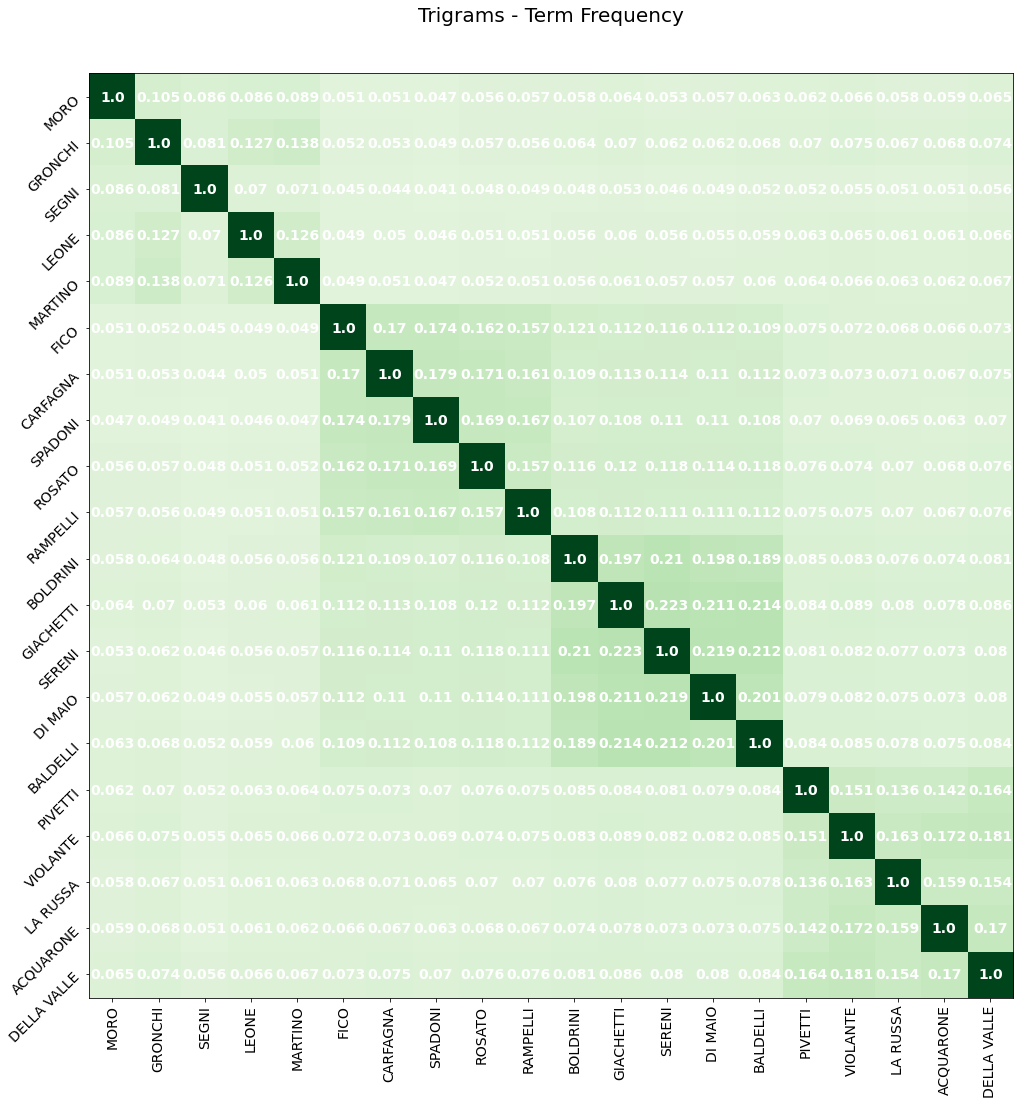

In [69]:
heatmap_cosine(data, data_tf, 'Trigrams - Term Frequency', 'trigrams_TF')

#### TFIDF

In [70]:
DF = {}
N = len(discorsi_analisi)

for cog in TF.keys():
    for term in TF[cog].keys():
        if term not in DF.keys():
            DF[term] = 1
        else:
            DF[term] = DF[term] +1
            
IDF = lambda x: np.log(N / DF[x])

<b> Trigram filtrato </b>

In [71]:
IDF_red = lambda x: np.log(N / DF_reduct[x])

In [72]:
DF_reduct = {k:DF[k] for k in DF.keys() if DF[k]>1} #rimuovo trigram che appaiono in un solo politico

In [73]:
TfIdf_reduct = {}

for cog, bow in TF.items():
    TfIdf_reduct[cog] = {w:round(bow[w] * IDF_red(w),3) for w in bow.keys() if w in DF_reduct.keys()} 

In [74]:
for cog in discorsi_analisi.keys():
    print(cog)
    pprint(list(sorted(TfIdf_reduct[cog].items(), key=lambda x: -x[1]))[:10])

MORO
[('del patto atlantico', 1.252),
 ('di nuovo istituzione', 1.252),
 ('il giudice popolare', 1.243),
 ('dirigere del popolare', 1.238),
 ('n bis di', 1.228),
 ('capitolare spesa per', 1.224),
 ('istituto della giuria', 1.224),
 ('bis di nuovo', 1.224),
 ('del popolare all', 1.219),
 ('dio giudico popolare', 1.219)]
GRONCHI
[('essendovi iscrivere e', 1.175),
 ('poi votare a', 1.172),
 ('sar poi votare', 1.166),
 ('facolta di esprimere', 1.165),
 ('della spesare dell', 1.165),
 ('proseguire nella lettura', 1.164),
 ('camera avere udire', 1.164),
 ('stare congedare il', 1.163),
 ('seguire emendamento che', 1.163),
 ('chie stare congedare', 1.162)]
SEGNI
[('della foresta non', 1.257),
 ('della foresta mi', 1.241),
 ('foresta chiedere di', 1.213),
 ('e della foresta', 1.204),
 ('della foresta l', 1.199),
 ('della foresta ma', 1.192),
 ('e della loreste', 1.188),
 ('mila lira di', 1.188),
 ('com mercio chiedere', 1.181),
 ('potere accettare l', 1.179)]
LEONE
[('il atto a', 1.18),
 ('atto

In [75]:
words_tfidf = {}
for cog in discorsi_analisi.keys():
    words_tfidf[cog] = list(TfIdf_reduct[cog].keys())

In [76]:
data_tfidf = {} 

for cog in discorsi_analisi.keys():
    data_tfidf[cog] = []
    print(datetime.now())
    print(cog)
    for c in discorsi_analisi.keys():
        words_pair = set()
        words_pair = set(words_tfidf[cog]).union(set(words_tfidf[c]))
                
        val = similarity_tf(cog,c,words_pair, TfIdf_reduct)
        data_tfidf[cog].append((c,val)) 

2021-01-26 11:13:53.969508
MORO
2021-01-26 11:14:10.352757
GRONCHI
2021-01-26 11:14:29.936279
SEGNI
2021-01-26 11:14:41.387263
LEONE
2021-01-26 11:14:54.814556
MARTINO
2021-01-26 11:15:08.716101
ROBERTO FICO
2021-01-26 11:15:18.220898
MARIA ROSARIA CARFAGNA
2021-01-26 11:15:27.306207
MARIA EDERA SPADONI
2021-01-26 11:15:35.703039
ETTORE ROSATO
2021-01-26 11:15:45.426215
FABIO RAMPELLI
2021-01-26 11:15:56.554474
LAURA BOLDRINI
2021-01-26 11:16:09.459567
ROBERTO GIACHETTI
2021-01-26 11:16:25.740401
MARINA SERENI
2021-01-26 11:16:38.996246
LUIGI DI MAIO
2021-01-26 11:16:52.582333
SIMONE BALDELLI
2021-01-26 11:17:07.102679
IRENE PIVETTI
2021-01-26 11:17:18.131061
LUCIANO VIOLANTE
2021-01-26 11:17:31.486713
IGNAZIO LA RUSSA
2021-01-26 11:17:43.337675
LORENZO ACQUARONE
2021-01-26 11:17:57.442183
RAFFAELE DELLA \ALLE


In [77]:
data = create_matrix(data_tfidf)

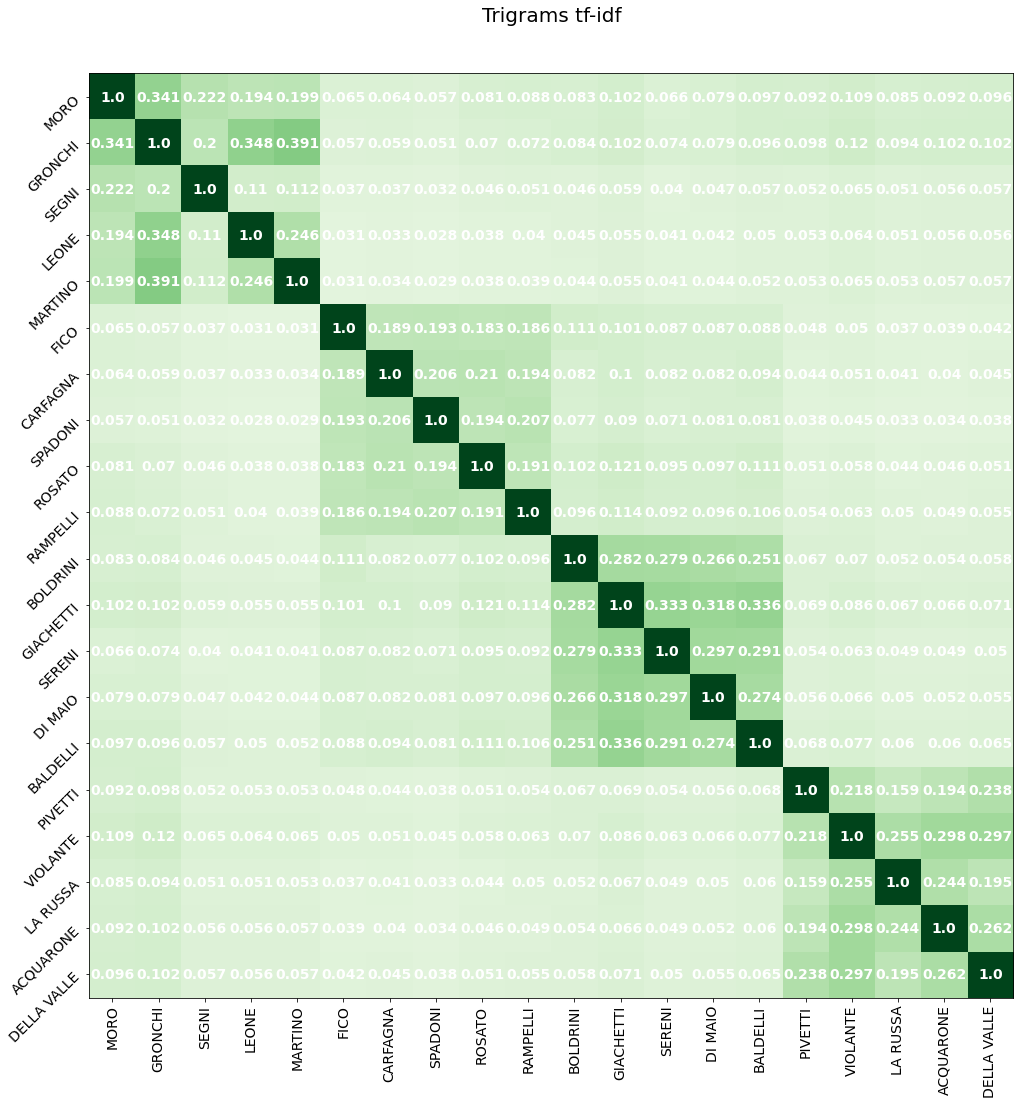

In [78]:
heatmap_cosine(data, data_tfidf, 'Trigrams tf-idf', 'trigrams_tfidf_filt') # filtered

<b> Versione non filtrata </b>

In [79]:
TfIdf = {}
for cog, bow in TF.items():
    TfIdf[cog] = {w:round(bow[w] * IDF(w),3) for w in bow.keys()}

In [80]:
for cog in discorsi_analisi.keys():
    print(cog)
    pprint(list(sorted(TfIdf[cog].items(), key=lambda x: -x[1]))[:10])

MORO
[('l industriare zolfifera', 1.598),
 ('industriare zolfifera siciliano', 1.592),
 ('che la giuria', 1.592),
 ('favore della cooperazione', 1.567),
 ('della giuria e', 1.561),
 ('anteriore a quello', 1.561),
 ('n per lira', 1.554),
 ('ammiraglio di squadrare', 1.554),
 ('vivo applauso all', 1.548),
 ('l aumentare supplementare', 1.548)]
GRONCHI
[('si proseguire nella', 1.516),
 ('nella lettura dio', 1.514),
 ('approvare si proseguire', 1.512),
 ('collegio unico nazionale', 1.511),
 ('capitolare da lira', 1.508),
 ('modificazione al regolamentare', 1.508),
 ('mezzadro colono o', 1.508),
 ('spesare del l', 1.508),
 ('di modificazione al', 1.508),
 ('scrutinio segreto discussione', 1.506)]
SEGNI
[('della foresta chiedere', 1.575),
 ('foresta mi onorare', 1.557),
 ('  ministrare dell', 1.554),
 ('ugricoltura e della', 1.548),
 ('ayricoltura e della', 1.54),
 ('e della ioreste', 1.537),
 ('dell ugricoltura e', 1.537),
 ('agricolturu e della', 1.537),
 ('dell ayricoltura e', 1.534),
 ('

In [81]:
words_tfidf = {}
for cog in discorsi_analisi.keys():
    words_tfidf[cog] = list(TfIdf[cog].keys())

In [82]:
data_tfidf = {} 
for cog in discorsi_analisi.keys():
    data_tfidf[cog] = []
    print(datetime.now())
    print(cog)
    for c in discorsi_analisi.keys():
        words_pair = set()
        words_pair = set(words_tfidf[cog]).union(set(words_tfidf[c]))
                
        val = similarity_tf(cog,c,words_pair, TfIdf)
        data_tfidf[cog].append((c,val)) # qui

2021-01-26 11:22:20.892609
MORO
2021-01-26 11:23:35.549561
GRONCHI
2021-01-26 11:25:03.493404
SEGNI
2021-01-26 11:25:40.607723
LEONE
2021-01-26 11:26:21.223443
MARTINO
2021-01-26 11:27:02.892765
ROBERTO FICO
2021-01-26 11:27:30.716295
MARIA ROSARIA CARFAGNA
2021-01-26 11:27:58.518248
MARIA EDERA SPADONI
2021-01-26 11:28:24.929406
ETTORE ROSATO
2021-01-26 11:28:56.171771
FABIO RAMPELLI
2021-01-26 11:29:28.892354
LAURA BOLDRINI
2021-01-26 11:30:08.045969
ROBERTO GIACHETTI
2021-01-26 11:30:56.613955
MARINA SERENI
2021-01-26 11:31:33.923820
LUIGI DI MAIO
2021-01-26 11:32:11.977110
SIMONE BALDELLI
2021-01-26 11:32:54.865129
IRENE PIVETTI
2021-01-26 11:33:27.446728
LUCIANO VIOLANTE
2021-01-26 11:34:09.043466
IGNAZIO LA RUSSA
2021-01-26 11:34:41.254455
LORENZO ACQUARONE
2021-01-26 11:35:17.712751
RAFFAELE DELLA \ALLE


In [83]:
data = create_matrix(data_tfidf)

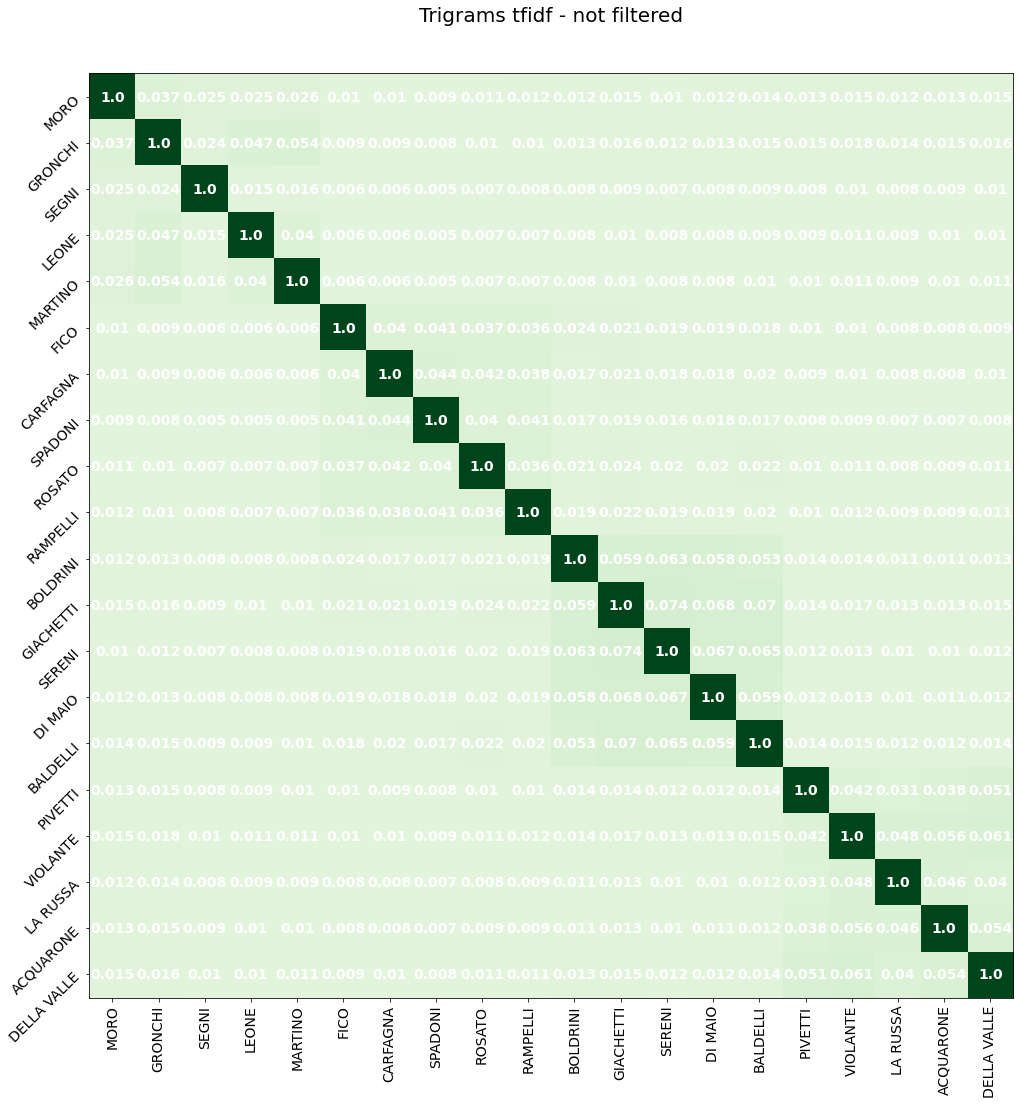

In [84]:
heatmap_cosine(data, data_tfidf, 'Trigrams tfidf - not filtered', 'trigrams_tfidf_nofilt')

## Bigrams

#### TF

In [85]:
TF, k = {}, 0.5 
cont = 0
separator = ' '

for cog in list(testo.keys()):
    join_bigrams = []
    
    for d in testo[cog]:
        text = token_ngram(d)
        bi_tokens = bigrams(text)
        join_bigrams.extend([str(item[0]+" "+item[1]) for item in bi_tokens])
    
    freq = Counter(join_bigrams).most_common() #le stopwrods le ho già tolte
    
    max_freq = freq[0][1]
    TF[cog] = {elem[0]: k+(1-k)*(elem[1]/max_freq) for elem in freq} #ogni politico è come se fosse un documento
    print(cog) #qui

MORO
GRONCHI
SEGNI
LEONE
MARTINO
ROBERTO FICO
MARIA ROSARIA CARFAGNA
MARIA EDERA SPADONI
ETTORE ROSATO
FABIO RAMPELLI
LAURA BOLDRINI
ROBERTO GIACHETTI
MARINA SERENI
LUIGI DI MAIO
SIMONE BALDELLI
IRENE PIVETTI
LUCIANO VIOLANTE
IGNAZIO LA RUSSA
LORENZO ACQUARONE
RAFFAELE DELLA \ALLE


In [86]:
list(sorted(TF['MORO'].items(), key=lambda x: -x[1]))[:10] 

[('che il', 1.0),
 ('per il', 0.9193548387096775),
 ('per la', 0.8860672614962251),
 ('che la', 0.8352779684282773),
 ('che si', 0.8050789293067948),
 ('che avere', 0.801990391214825),
 ('che non', 0.7841455044612217),
 ('di questo', 0.7817433081674674),
 ('che essere', 0.7817433081674674),
 ('e di', 0.7481125600549073)]

In [88]:
words_tf = {}
for cog in testo.keys():
    words_tf[cog] = list(TF[cog].keys())

In [89]:
data_tf = {}

for cog in testo.keys():
    data_tf[cog] = []
    for c in testo.keys():
        words_pair = set()
        words_pair = set(words_tf[cog]).union(set(words_tf[c]))
            
        val = similarity_tf(cog,c,words_pair, TF)
        data_tf[cog].append((c,val))
    print(cog)

MORO
GRONCHI
SEGNI
LEONE
MARTINO
ROBERTO FICO
MARIA ROSARIA CARFAGNA
MARIA EDERA SPADONI
ETTORE ROSATO
FABIO RAMPELLI
LAURA BOLDRINI
ROBERTO GIACHETTI
MARINA SERENI
LUIGI DI MAIO
SIMONE BALDELLI
IRENE PIVETTI
LUCIANO VIOLANTE
IGNAZIO LA RUSSA
LORENZO ACQUARONE
RAFFAELE DELLA \ALLE


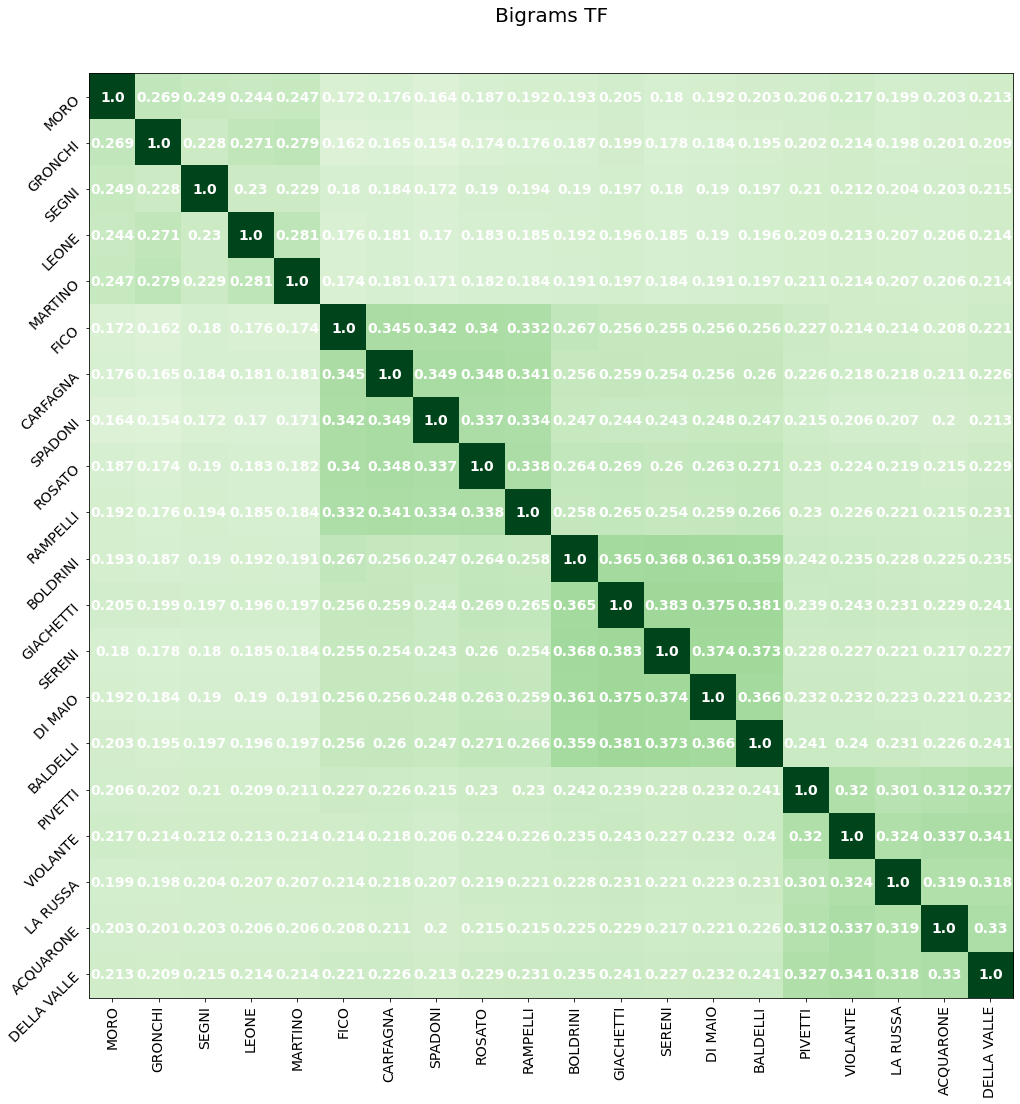

In [90]:
data = create_matrix(data_tf)
heatmap_cosine(data, data_tf, 'Bigrams TF', 'bigrams_tf_filt')

<b> TFIDF </b>

In [ ]:
DF = {}
N = len(discorsi_analisi)

for cog in TF.keys():
    for term in TF[cog].keys():
        if term not in DF.keys():
            DF[term] = 1
        else:
            DF[term] = DF[term] +1
            
IDF = lambda x: np.log(N / DF[x])

In [92]:
IDF_red = lambda x: np.log(N / DF_reduct[x])

In [93]:
DF_reduct = {k:DF[k] for k in DF.keys() if DF[k]>1}

In [94]:
TfIdf_reduct = {}
for cog, bow in TF.items():
    TfIdf_reduct[cog] = {w:round(bow[w] * IDF_red(w),3) for w in bow.keys() if w in DF_reduct.keys()} 

In [96]:
for cog in discorsi_analisi.keys():
    print(cog)
    pprint(list(sorted(TfIdf_reduct[cog].items(), key=lambda x: -x[1]))[:10])

MORO
[('giudice popolare', 1.176),
 ('industriare zolfifera', 1.17),
 ('capitolare spesa', 1.167),
 ('del riarmare', 1.167),
 ('il giurare', 1.166),
 ('n lira', 1.164),
 ('il fitto', 1.164),
 ('giuria e', 1.164),
 ('mila vano', 1.164),
 ('di film', 1.163)]
GRONCHI
[('stare congedare', 1.159),
 ('dio rias', 1.158),
 ('grasso candidare', 1.158),
 ('votazione li', 1.158),
 ('segreto discussione', 1.158),
 ('leggere revisione', 1.157),
 ('chiedere congedo', 1.157),
 ('congedo il', 1.157),
 ('adonnino almirante', 1.156),
 ('locatore o', 1.156)]
SEGNI
[('foresta non', 1.229),
 ('foresta chiedere', 1.198),
 ('foresta ma', 1.182),
 ('della loreste', 1.177),
 ('reddito unitario', 1.172),
 ('agricoltzira e', 1.169),
 ('tregua mezzadrile', 1.169),
 ('clell agricoltura', 1.169),
 ('ngricoltura e', 1.169),
 ('mercio mi', 1.169)]
LEONE
[('ed equiparare', 1.165),
 ('fra interrogare', 1.162),
 ('reclusione fino', 1.162),
 ('messinetti grifone', 1.16),
 ('onorevole amatucci', 1.16),
 ('onorevole helfer

In [98]:
words_tfidf = {}
for cog in discorsi_analisi.keys():
    words_tfidf[cog] = list(TfIdf_reduct[cog].keys())

In [101]:
data_tfidf = {} 

for cog in discorsi_analisi.keys():
    data_tfidf[cog] = []
    print(datetime.now())
    print(cog)
    for c in  discorsi_analisi.keys():
        words_pair = set()
        words_pair = set(words_tfidf[cog]).union(set(words_tfidf[c]))
                
        val = similarity_tf(cog,c,words_pair, TfIdf_reduct)
        data_tfidf[cog].append((c,val)) 

2021-01-26 12:27:49.040573
MORO
2021-01-26 12:28:04.555421
GRONCHI
2021-01-26 12:28:21.156526
SEGNI
2021-01-26 12:28:32.371006
LEONE
2021-01-26 12:28:45.073366
MARTINO
2021-01-26 12:28:57.347543
ROBERTO FICO
2021-01-26 12:29:06.046393
MARIA ROSARIA CARFAGNA
2021-01-26 12:29:14.657618
MARIA EDERA SPADONI
2021-01-26 12:29:22.785376
ETTORE ROSATO
2021-01-26 12:29:31.735613
FABIO RAMPELLI
2021-01-26 12:29:40.256285
LAURA BOLDRINI
2021-01-26 12:29:50.252091
ROBERTO GIACHETTI
2021-01-26 12:30:02.254511
MARINA SERENI
2021-01-26 12:30:13.663990
LUIGI DI MAIO
2021-01-26 12:30:25.939309
SIMONE BALDELLI
2021-01-26 12:30:37.912855
IRENE PIVETTI
2021-01-26 12:30:46.857788
LUCIANO VIOLANTE
2021-01-26 12:30:57.481308
IGNAZIO LA RUSSA
2021-01-26 12:31:06.125342
LORENZO ACQUARONE
2021-01-26 12:31:15.748727
RAFFAELE DELLA \ALLE


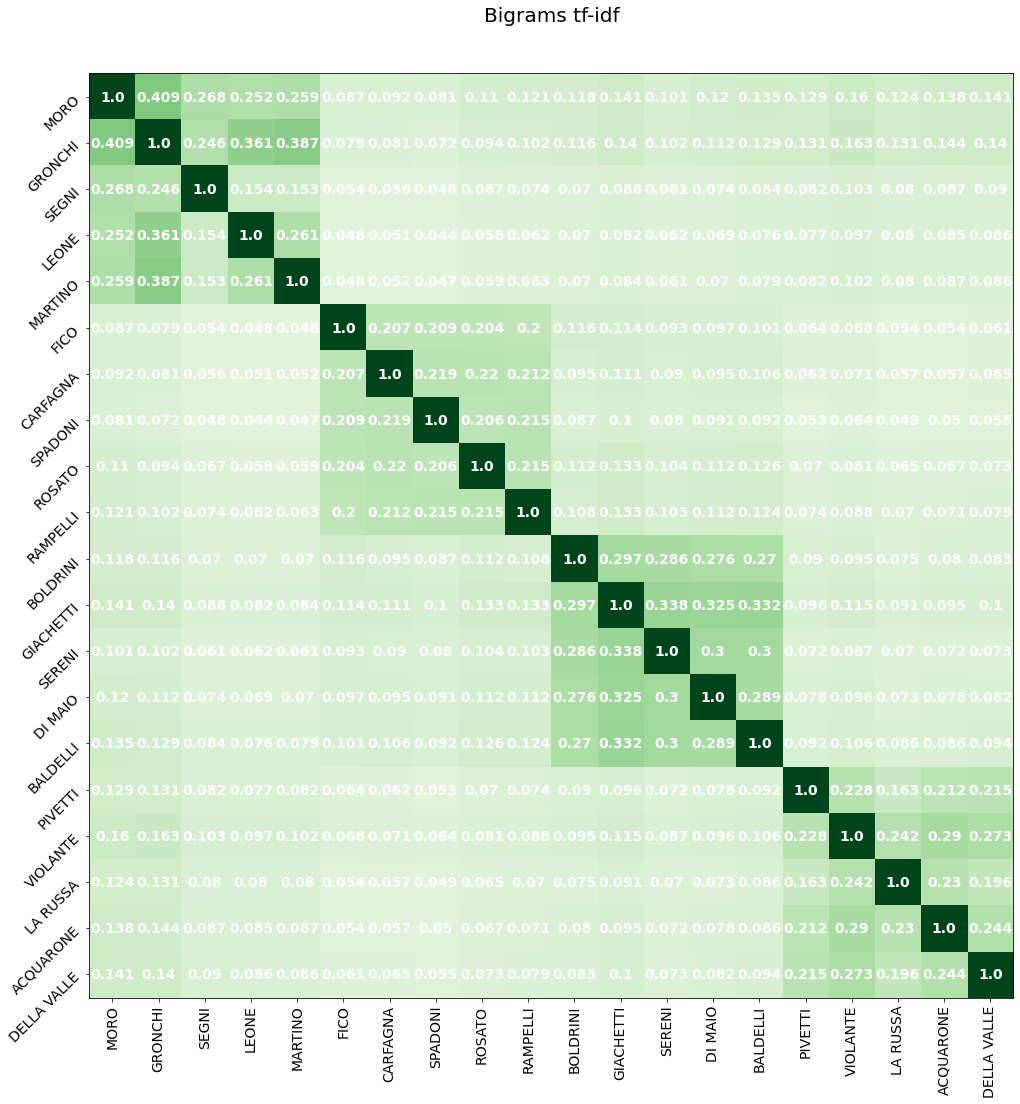

In [102]:
data = create_matrix(data_tfidf)
heatmap_cosine(data, data_tfidf, 'Bigrams tf-idf','bigrams_tfidf_filt')

<b> Tfidf non filtrato </b>

In [103]:
TfIdf = {}
for cog, bow in TF.items():
    TfIdf[cog] = {w:round(bow[w] * IDF(w),3) for w in bow.keys()}

In [104]:
for cog in discorsi_analisi.keys():
    print(cog)
    pprint(list(sorted(TfIdf[cog].items(), key=lambda x: -x[1]))[:10])

MORO
[('zolfifera siciliano', 1.518),
 ('giuria non', 1.515),
 ('film italiano', 1.514),
 ('neo laureato', 1.509),
 ('onorevole brusasca', 1.509),
 ('  zione', 1.508),
 ('un industriare', 1.507),
 ('sezione tecnico', 1.507),
 ('film americano', 1.507),
 ('funzione direttivo', 1.507)]
GRONCHI
[('capitolare da', 1.508),
 ('mezzadro colono', 1.507),
 ('affittuario mezzadro', 1.503),
 ('capitolare si', 1.503),
 ('n alcuno', 1.503),
 ('alcuno chiedere', 1.503),
 ('quattro esperto', 1.503),
 ('del notariato', 1.503),
 ('lioni lioni', 1.503),
 ('negato porre', 1.503)]
SEGNI
[('ugricoltura e', 1.534),
 ('reddito catastale', 1.531),
 ('agricolturu e', 1.529),
 ('della ioreste', 1.527),
 ('ayricoltura e', 1.527),
 ('dell ugricoltura', 1.525),
 ('dell ayricoltura', 1.523),
 ('dell agricolturu', 1.523),
 ('zona agrario', 1.521),
 ('della joreste', 1.519)]
LEONE
[('posto aumentare', 1.514),
 ('equiparare essere', 1.514),
 ('esame punto', 1.51),
 ('olindo corbi', 1.51),
 ('giorgio cremaschi', 1.51),

In [105]:
words_tfidf = {}
for cog in discorsi_analisi.keys():
    words_tfidf[cog] = list(TfIdf[cog].keys())

In [106]:
data_tfidf = {} 
for cog in discorsi_analisi.keys():
    data_tfidf[cog] = []
    print(datetime.now())
    print(cog)
    for c in discorsi_analisi.keys():
        words_pair = set()
        words_pair = set(words_tfidf[cog]).union(set(words_tfidf[c]))
                
        val = similarity_tf(cog,c,words_pair, TfIdf)
        data_tfidf[cog].append((c,val)) # qui

2021-01-26 13:33:04.833717
MORO
2021-01-26 13:33:39.386946
GRONCHI
2021-01-26 13:34:19.745770
SEGNI
2021-01-26 13:34:38.139929
LEONE
2021-01-26 13:34:58.381367
MARTINO
2021-01-26 13:35:19.453713
ROBERTO FICO
2021-01-26 13:35:35.045356
MARIA ROSARIA CARFAGNA
2021-01-26 13:35:49.522487
MARIA EDERA SPADONI
2021-01-26 13:36:05.764193
ETTORE ROSATO
2021-01-26 13:36:23.535111
FABIO RAMPELLI
2021-01-26 13:36:41.312017
LAURA BOLDRINI
2021-01-26 13:36:59.580744
ROBERTO GIACHETTI
2021-01-26 13:37:21.086151
MARINA SERENI
2021-01-26 13:37:39.249281
LUIGI DI MAIO
2021-01-26 13:38:01.615571
SIMONE BALDELLI
2021-01-26 13:38:24.054889
IRENE PIVETTI
2021-01-26 13:38:42.639642
LUCIANO VIOLANTE
2021-01-26 13:39:04.583672
IGNAZIO LA RUSSA
2021-01-26 13:39:20.456500
LORENZO ACQUARONE
2021-01-26 13:39:37.827399
RAFFAELE DELLA \ALLE


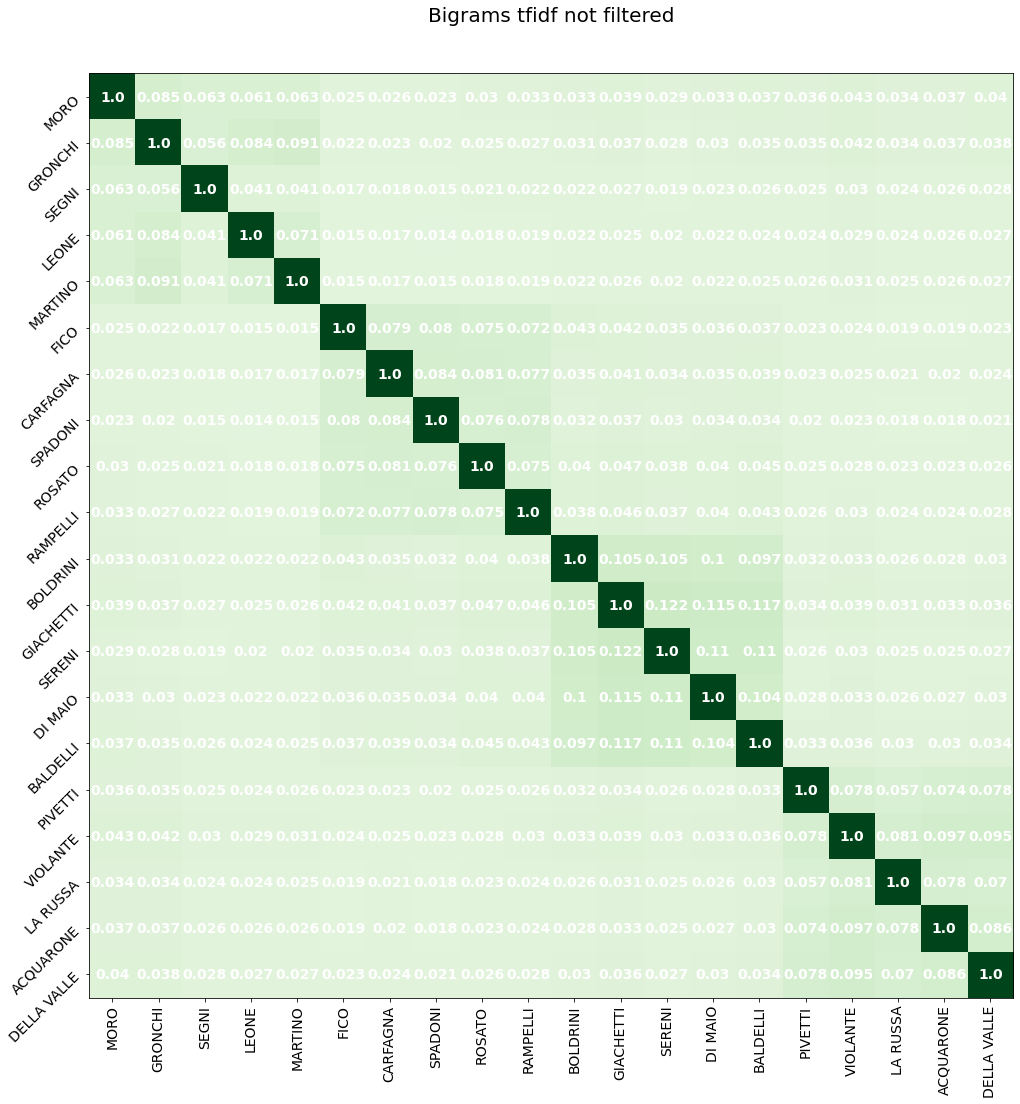

In [107]:
data = create_matrix(data_tfidf)
heatmap_cosine(data, data_tfidf, 'Bigrams tfidf not filtered','bigrams_tfidf_notfilt')